# Intro to Data Processing on AWS

One of the more difficult things for me when getting started with Spark was understanding what was happening under the hood.

This notebook is an example to demonstrate what happens when you read both raw (TSV) and optimized (Apache Parquet) data from S3 using Apache Spark.

First, I'm going to create a new EMR cluster with 10 `c5.4xlarge` instances. Each instance has 16 vCPUs and 32 GiB of memory.

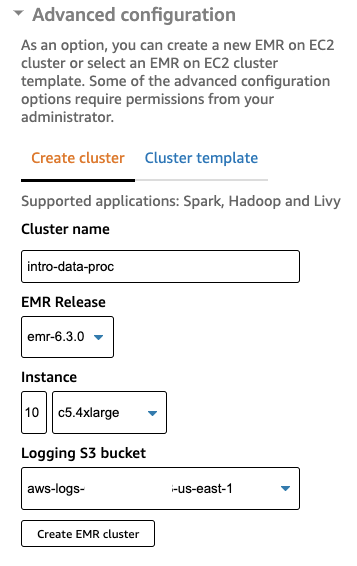

## Connect and Start Spark

Next we connect to the cluster and configure Spark to use Cluster mode. By default, EMR is configured to use all resources in the cluster, but we will tell Spark to use "cluster" deployment mode.

In [1]:
%%configure -f
{
    "conf": {
        "spark.submit.deployMode": "cluster"
    }
}

First, let's just make sure Spark is up and running

In [2]:
%%spark

numbers = sc.parallelize([1,2,3,4])
numbers.collect()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1625869168028_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[1, 2, 3, 4]

Cool, so Spark is working. Let's dig in to how Spark reads data.

## Read a big CSV file

One of the great things about Spark is that it can parallelize data processing. *BUT* it can only do that if the underlying file type supports that. 

Often times you're starting with CSV data or gzip'ed data. Let's see what happens with each of those.

I'm going to use a "fairly large" CSV from the [Washington Post's DEA Pain Pills database](https://www.washingtonpost.com/national/2019/07/18/how-download-use-dea-pain-pills-database/):

```shell
aws s3 ls s3://emr-da-demo-us-east-2/intro-to-data-processing/csv/ --human
2021-06-03 17:33:51   74.5 GiB arcos_all_washpost.tsv
2021-06-03 17:22:46    6.4 GiB arcos_all_washpost.tsv.gz
```

First, let's see what happens when we try to read the TSV file directly.

In [3]:
sc.setJobDescription("TSV / INFER")
df = spark.read.format("csv") \
    .option("inferSchema", "true") \
    .option("sep","\t") \
    .option("header", "true") \
    .load("s3://emr-da-demo-us-east-2/intro-to-data-processing/csv/arcos_all_washpost.tsv")

df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- REPORTER_DEA_NO: string (nullable = true)
 |-- REPORTER_BUS_ACT: string (nullable = true)
 |-- REPORTER_NAME: string (nullable = true)
 |-- REPORTER_ADDL_CO_INFO: string (nullable = true)
 |-- REPORTER_ADDRESS1: string (nullable = true)
 |-- REPORTER_ADDRESS2: string (nullable = true)
 |-- REPORTER_CITY: string (nullable = true)
 |-- REPORTER_STATE: string (nullable = true)
 |-- REPORTER_ZIP: integer (nullable = true)
 |-- REPORTER_COUNTY: string (nullable = true)
 |-- BUYER_DEA_NO: string (nullable = true)
 |-- BUYER_BUS_ACT: string (nullable = true)
 |-- BUYER_NAME: string (nullable = true)
 |-- BUYER_ADDL_CO_INFO: string (nullable = true)
 |-- BUYER_ADDRESS1: string (nullable = true)
 |-- BUYER_ADDRESS2: string (nullable = true)
 |-- BUYER_CITY: string (nullable = true)
 |-- BUYER_STATE: string (nullable = true)
 |-- BUYER_ZIP: integer (nullable = true)
 |-- BUYER_COUNTY: string (nullable = true)
 |-- TRANSACTION_CODE: string (nullable = true)
 |-- DRUG_CODE: integer (null

This generates 2 jobs with 1 task and 597 tasks and if we look at the stage details in the Spark UI, we can see each task is loading 128MB of data...and we can also see in the logs where each task is reading a slice of that CSV file.

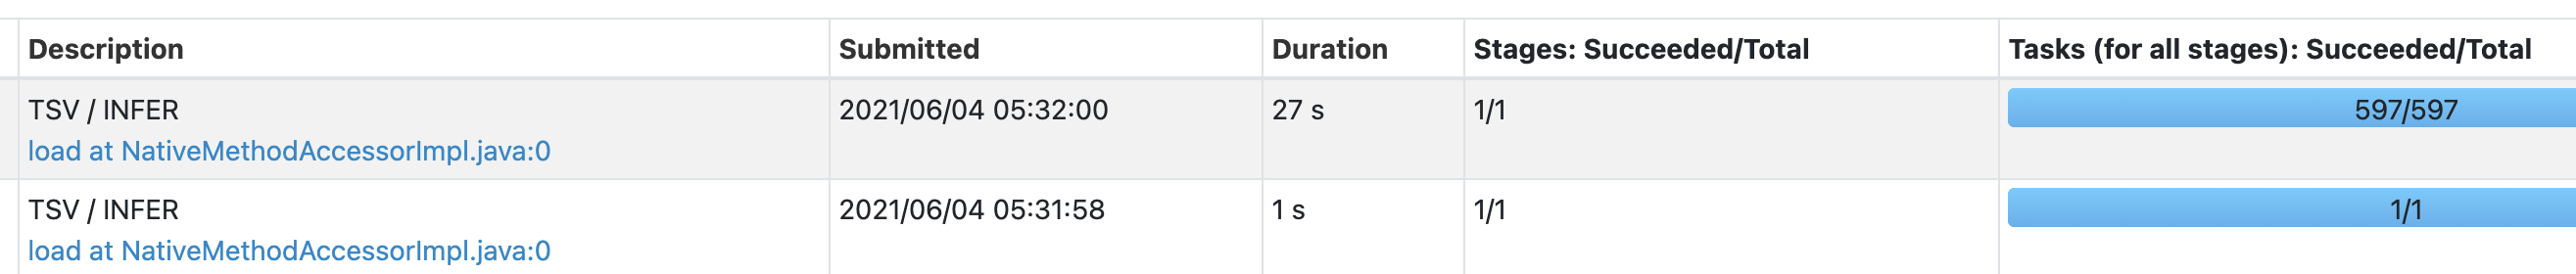

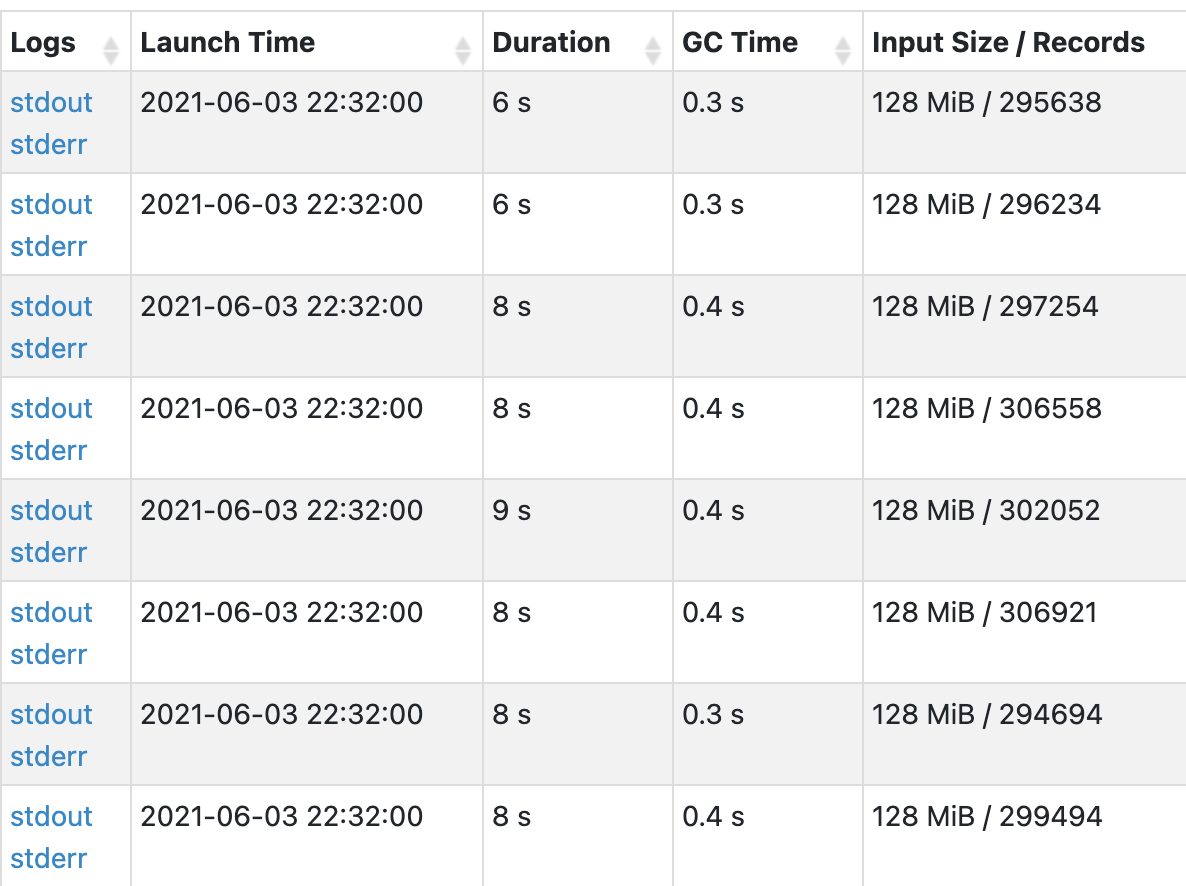

What happens if we load it _without_ inferring the schema?

In [4]:
sc.setJobDescription("TSV / NOINFER")
df = spark.read.format("csv") \
    .option("sep","\t") \
    .option("header", "true") \
    .load("s3://emr-da-demo-us-east-2/intro-to-data-processing/csv/arcos_all_washpost.tsv")

df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- REPORTER_DEA_NO: string (nullable = true)
 |-- REPORTER_BUS_ACT: string (nullable = true)
 |-- REPORTER_NAME: string (nullable = true)
 |-- REPORTER_ADDL_CO_INFO: string (nullable = true)
 |-- REPORTER_ADDRESS1: string (nullable = true)
 |-- REPORTER_ADDRESS2: string (nullable = true)
 |-- REPORTER_CITY: string (nullable = true)
 |-- REPORTER_STATE: string (nullable = true)
 |-- REPORTER_ZIP: string (nullable = true)
 |-- REPORTER_COUNTY: string (nullable = true)
 |-- BUYER_DEA_NO: string (nullable = true)
 |-- BUYER_BUS_ACT: string (nullable = true)
 |-- BUYER_NAME: string (nullable = true)
 |-- BUYER_ADDL_CO_INFO: string (nullable = true)
 |-- BUYER_ADDRESS1: string (nullable = true)
 |-- BUYER_ADDRESS2: string (nullable = true)
 |-- BUYER_CITY: string (nullable = true)
 |-- BUYER_STATE: string (nullable = true)
 |-- BUYER_ZIP: string (nullable = true)
 |-- BUYER_COUNTY: string (nullable = true)
 |-- TRANSACTION_CODE: string (nullable = true)
 |-- DRUG_CODE: string (nullabl

Awesome, so that loads super quick (5s vs. 27s). *BUT* it only had one task that loaded ~15 KiB of data. This is because Spark just samples the CSV file.

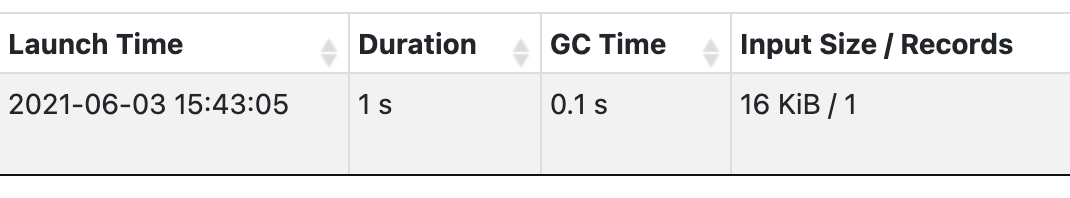

If we do a `df.count()` then we again see 598 tasks of 128MiB each.

In [5]:
sc.setJobDescription("TSV / NOINFER / count()")

df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

178598026

### Question 1: Where does the 128 MiB come from?

By default, [Spark configuration](https://spark.apache.org/docs/latest/configuration.html) uses 134217728 (128 MiB) as the `spark.files.maxPartitionBytes` setting.

That means that it'll take the 79996770669 byte (74.5 GiB) file and split it up into roughly ~128 MiB chunks. That gives us:

In [24]:
%%local
79996770669 / 134217728

596.0223873630166

Rounding up, that's 597 tasks!

OK cool! Out of curiosity, how many executors do we have? In order do that, we can query the Spark REST API.

First, we'll get the address of the history server from the Spark config

In [ ]:
%%spark -o df

history_server = sc.getConf().get('spark.yarn.historyServer.address')
df = spark.read.json(sc.parallelize(['{"address": "http://' + history_server + '"}']))

Then we'll write a quick bit of code to get our application ID and print out some executor stats.

In [ ]:
%%local

import requests

def get_applications(history_server_endpoint : str):
    x = requests.get(f"{history_server_endpoint}/api/v1/applications")
    return x.json()

def get_most_recent_application_id(history_server_endpoint : str):
    apps = get_applications(history_server_endpoint)
    return sorted(apps, key=lambda app: app.get('id'))[-1].get('id')

def get_executor_counts(history_server_endpoint : str, app_id : str):
    x = requests.get(f'{history_server_endpoint}/api/v1/applications/{app_id}/1/allexecutors')
    try:
        return len(x.json())
    except:
        return -1


history_server = df.address[0]
apps = get_applications(history_server)

# Print out a listing of the apps
for app in apps:
    app_id = app.get('id')
    print(f"{app_id} - {app.get('attempts')[0].get('completed')} - {get_executor_counts(history_server, app_id)} executors")
    
# And we'll assume the last app is the most recent one since this is just demo code
app_id = apps[-1].get('id')

#jobs = requests.get(f'{history_server}/api/v1/applications/{app_id}/1/jobs')
#print(jobs.json())

That...didn't really help us much, so we don't dig into it for now.


So can we tweak that `spark.files.maxPartitionBytes` if we (for whatever reason) want to change the size per partition?

We sure can! Let's trying setting it to 10MiB.

In [ ]:
%%local

10 * 1024 * 1024

In [ ]:
%%configure -f
{
    "conf": {
        "spark.submit.deployMode": "cluster",
        "spark.sql.files.maxPartitionBytes": 10485760
    }
}

In [ ]:
sc.setJobDescription("TSV / INFER / 10mib")

df = spark.read.format("csv") \
    .option("inferSchema", "true") \
    .option("sep","\t") \
    .option("header", "true") \
    .load("s3://emr-da-demo-us-east-2/intro-to-data-processing/csv/arcos_all_washpost.tsv")

In [ ]:
%%local

def print_task_counts(history_server_endpoint : str, app_id : str):
    x = requests.get(f"{history_server}/api/v1/applications/{app_id}/1/jobs")
    for job in x.json():
        startTime = datetime.strptime(job.get('submissionTime'), '%Y-%m-%dT%H:%M:%S.%fGMT')
        completionTime = datetime.strptime(job.get('completionTime'), '%Y-%m-%dT%H:%M:%S.%fGMT')
        diff = str(completionTime-startTime)
        print(f"Job ID {job.get('jobId')} ({job.get('description')}) - {job.get('numTasks')} tasks. Time: {diff}")

print_task_counts(history_server, "application_1622742481684_0009")

Cool, now we see 7,630 tasks!

In [ ]:
%%local

79996770669 / 10485760

Awesome! So now we've seen how Spark decides how much data to read in and how many tasks to create.

## Question 2: What happens if we have a non-splittable file?

This is probably the biggest pain when you're dealing with unwieldy input. Somebody sends you a link to a giant file, but *GOOD NEWS* it's gzip'ed. Bad news for you, the Spark Developer, because gzip is a non-splittable compression format. So what happens when you try to read that file?

In [ ]:
%%configure -f
{
    "conf": {
        "spark.submit.deployMode": "cluster"
    }
}

In [ ]:
sc.setJobDescription("TSV.gz / INFER")

df = spark.read.format("csv") \
    .option("inferSchema", "true") \
    .option("sep","\t") \
    .option("header", "true") \
    .load("s3://emr-da-demo-us-east-2/intro-to-data-processing/csv/arcos_all_washpost.tsv.gz")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

What we should see is a poor single task in Spark reading, gunziping, and processing this 6gb gz file. 

All in 17 minutes. 😭

But that's if we use `inferSchema=true`. If we don't, the job runs quickly as it only needs to read in the header since we're not doing anything with the data.

You can see in the screenshot below, taken midway through the `read` process, there's only one task running and it's read 2.7GiB in 6.9 minutes.
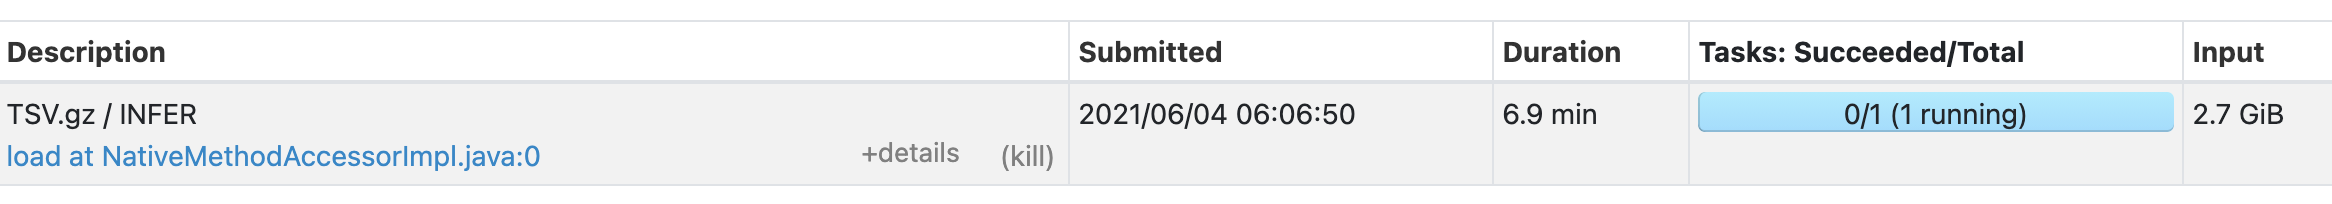

In [ ]:
sc.setJobDescription("TSV.gz / NOINFER")

df = spark.read.format("csv") \
    .option("sep","\t") \
    .option("header", "true") \
    .load("s3://emr-da-demo-us-east-2/intro-to-data-processing/csv/arcos_all_washpost.tsv.gz")

In [ ]:
%%local

print_task_counts(history_server, "application_1622742481684_0010")

## Question 2: What if we have a hard-coded set of executors and/or cores?

EMR by default is configured to maximize cluster utilization. The number of cores is determined per instance and Dynamic Resource Allocation is enabled by default.

On the `c5.4xlarge`, there are 4 cores per executor.

In [ ]:
print(sc.getConf().get('spark.executor.cores'))

In [ ]:
%%configure -f
{
    "numExecutors": 2,
    "executorCores": 4,
    "conf": {
        "spark.submit.deployMode": "cluster",
        "spark.dynamicAllocation.enabled": "false"
    }
}

In [ ]:
sc.setJobDescription("TSV / INFER / 4core_2exec")
df = spark.read.format("csv") \
    .option("inferSchema", "true") \
    .option("sep","\t") \
    .option("header", "true") \
    .load("s3://emr-da-demo-us-east-2/intro-to-data-processing/csv/arcos_all_washpost.tsv")

The same number of tasks is generated, but we can see there are only 2 executors that get spun up and the job takes longer to complete.

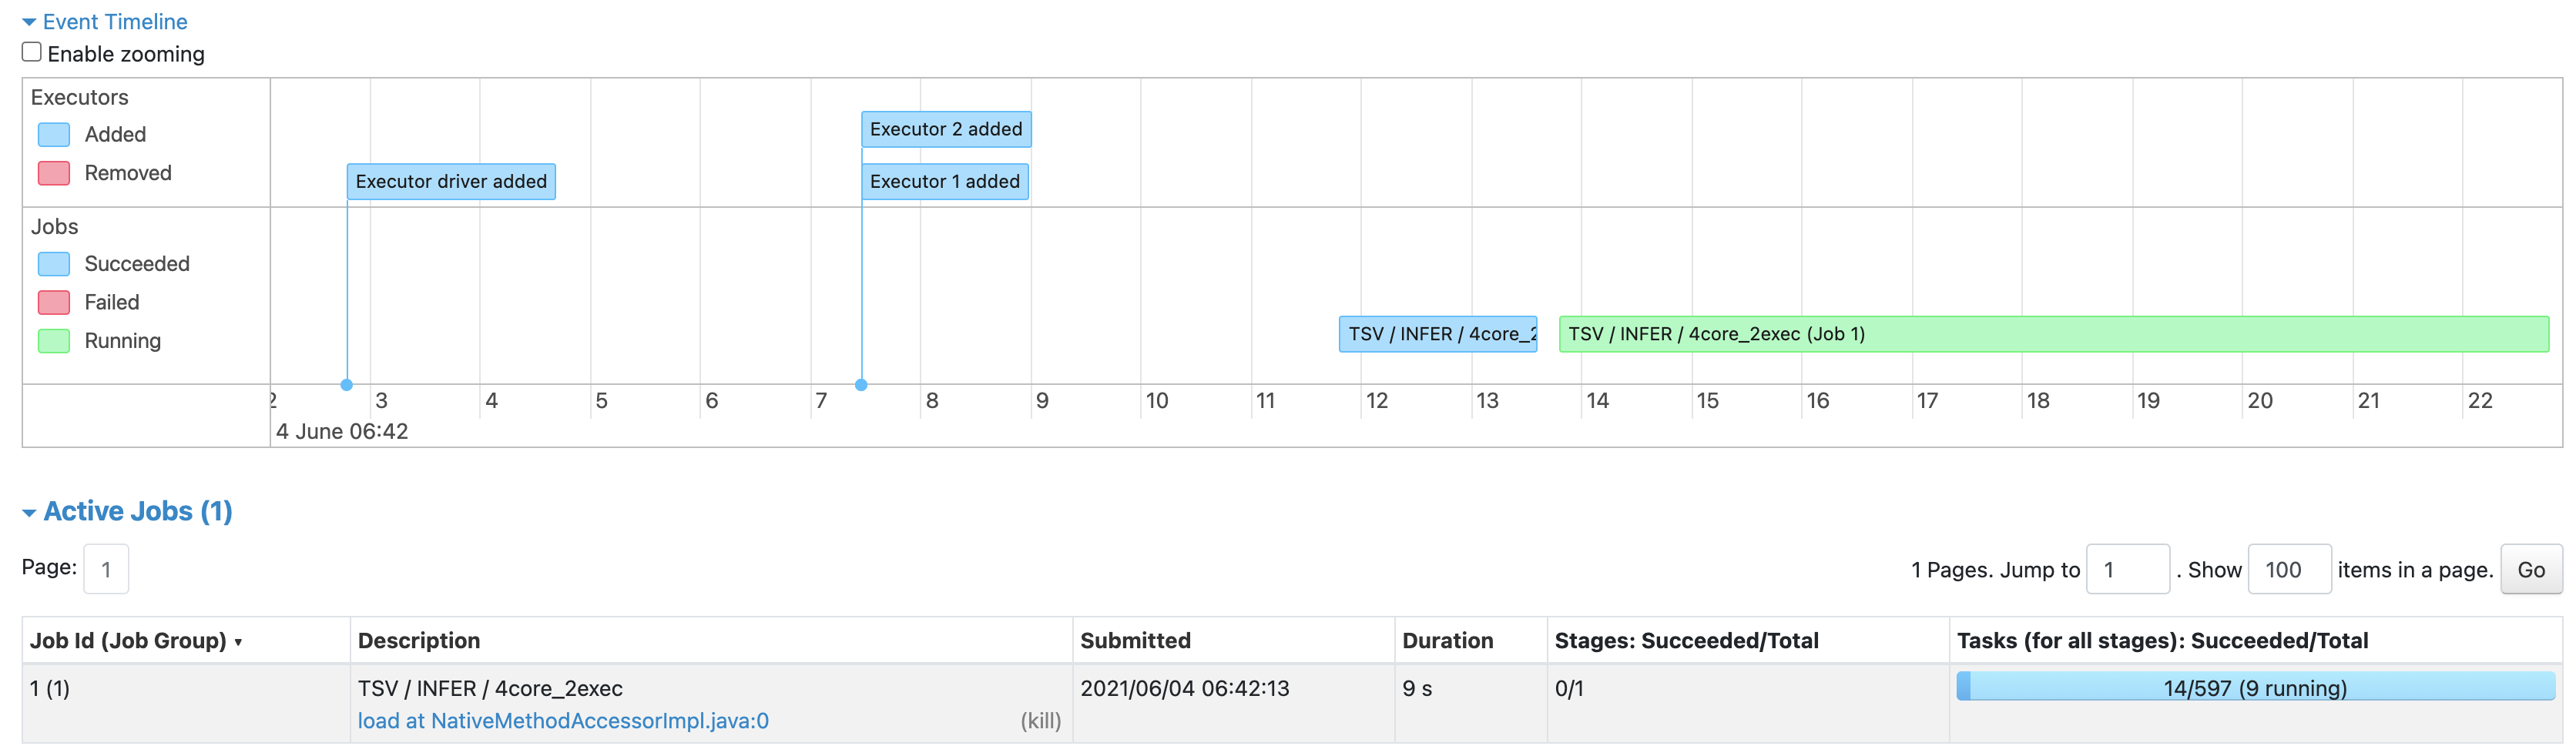

In [ ]:
%%local

print_task_counts(history_server, "application_1622742481684_0013")

Just so we have an idea of *just* how many executors we could run, let's calculate the capacity of our cluster.

First, we need to see how EMR has configured Spark executor cores and memeory.

In [ ]:
print(sc.getConf().get('spark.executor.cores'))
print(sc.getConf().get('spark.executor.memory'))

So on our c5.4xlarge, we've got 16 vCPUs and 32GiB of memory. If we look at the Spark UI of the application above, we'll see 1 Spark Driver starting up and 36 Spark Executors starting up.

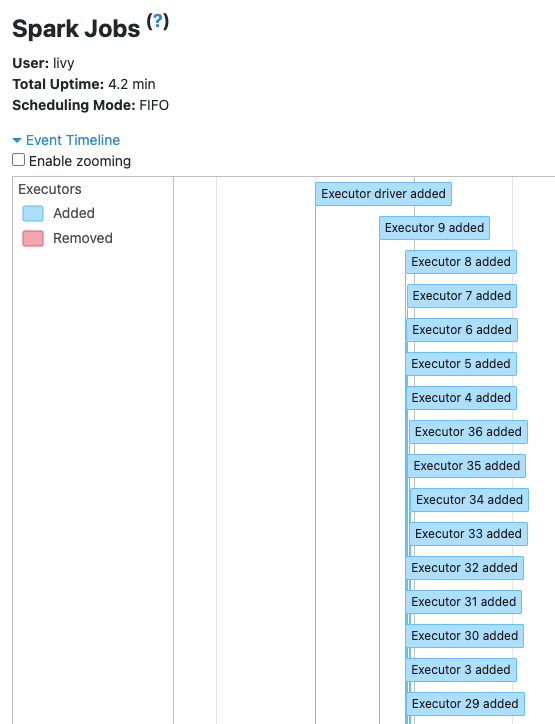

Let's see how many executors are running on each host.

In [ ]:
%%local

from collections import defaultdict

app_id = get_most_recent_application_id(history_server)

x = requests.get(f'{history_server}/api/v1/applications/{app_id}/1/allexecutors')

host_exec_count = defaultdict(int)
for exec in x.json():
    host = exec.get('hostPort').split(":")[0]
    host_exec_count[host]+=1

total_executors = 0
for count, k in enumerate(host_exec_count, start=1):
    print(f"Host #{count} --> {host_exec_count[k]} executors")
    total_executors += host_exec_count[k]

print(f"{total_executors} total executors")

So in our 10-node cluster, with 1 primary node and 9 core nodes we have 4 executors per node for a total of 36 executors.

## OK, talk to me about Parquet!

[Apache Parquet](https://parquet.apache.org/) is a binary, columnar storage format commonly used in big data applications.

It's a bit tough to wrap your head around, but think of it as taking a CSV file and grouping it by _columns_ instead of _rows.

I feel like this diagram illustrates it pretty well.

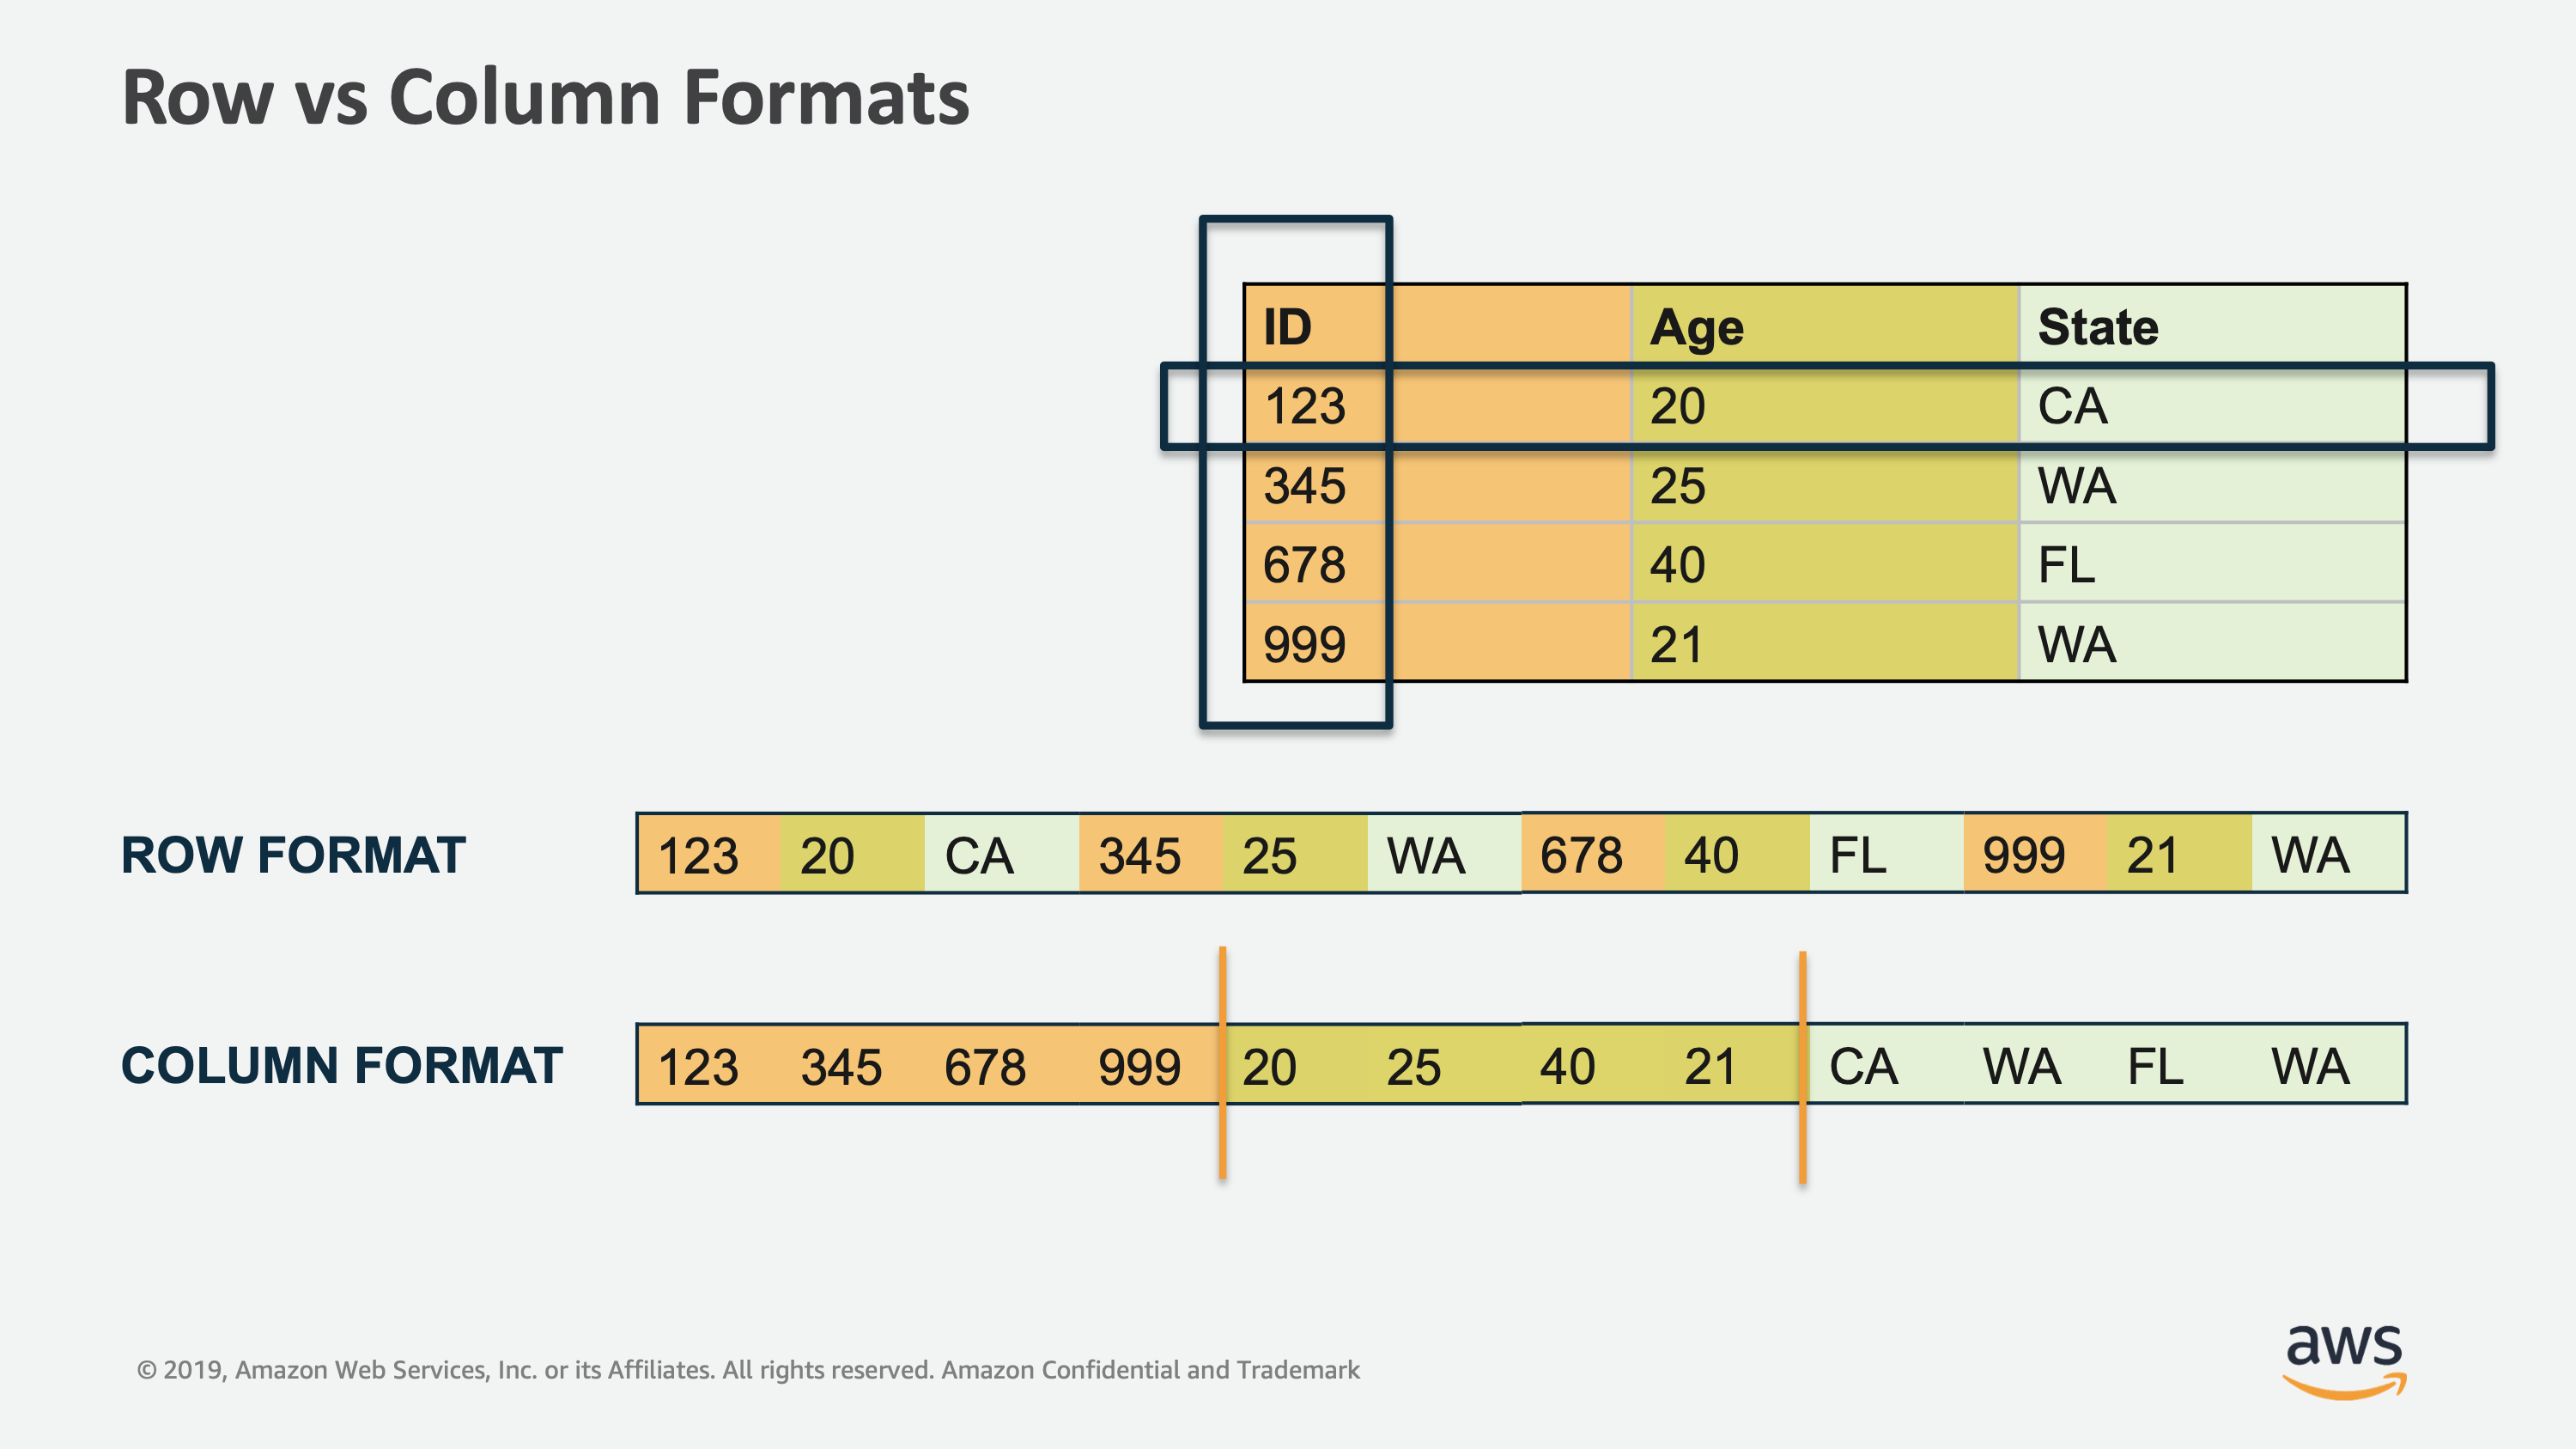

Not only that, but Parquet adds *metadata* to each column, each "page" of of data inside the Parquet file, *and* to the whole file.

I always love this image from the [Parquet documentation] that shows how much is packed inside of those files. It's almost like a little database!

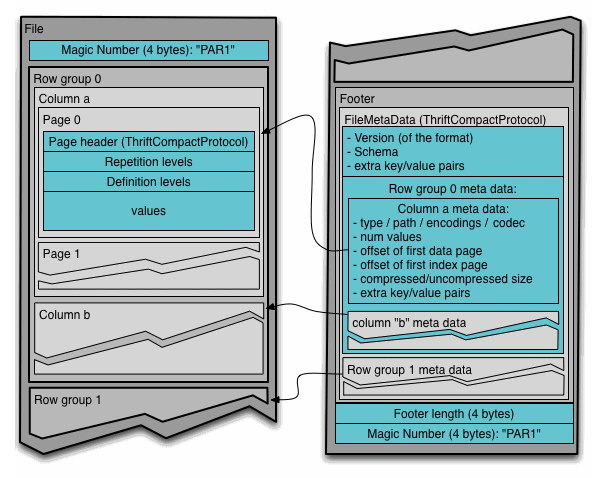

So let's convert our data to Parquet...let's refresh our cluster, read the data from scratch and convert it.

In [ ]:
%%configure -f
{
    "conf": {
        "spark.submit.deployMode": "cluster",
        "spark.dynamicAllocation.enabled": "true"
    }
}

In [6]:
sc.setJobDescription("TSV ->> Parquet")
df = spark.read.format("csv") \
    .option("inferSchema", "true") \
    .option("sep","\t") \
    .option("header", "true") \
    .load("s3://emr-da-demo-us-east-2/intro-to-data-processing/csv/arcos_all_washpost.tsv")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df.write.mode('overwrite').parquet("s3://emr-da-demo-us-east-2/intro-to-data-processing/parquet/default/")

Now if we list the target location, we'll see 597 parquet files!

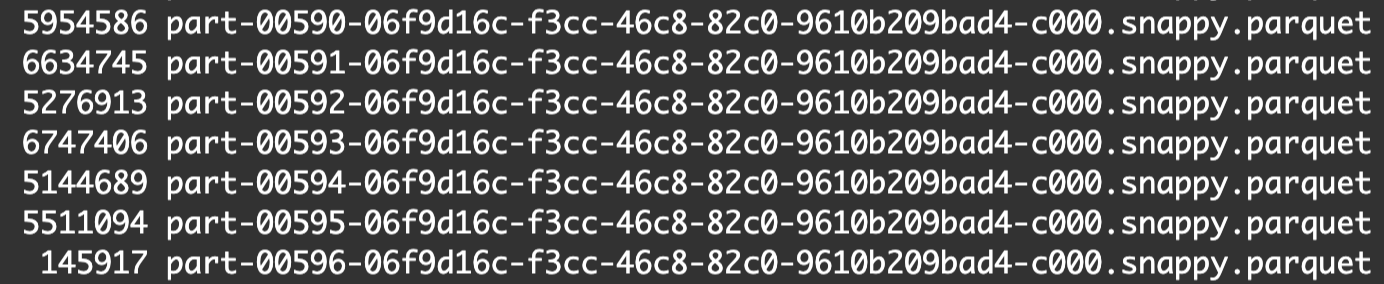

Wait, what?! That's right - by default, Spark writes out the number of partitions you have.

And in this case, because Parquet can aggregate and compress a lot of that data, each of those files is only about 5MiB.

_A QUICK DIVERSION ON FILE SIZES_

So, we now have 597 files of 5MiB each. 

If we tried to read all of the data from those files, we would be issuing *a lot* of requests to S3. Especially if we were doing something like `count(*)`. We'd have to open up each file, look at the header, read the metadata field, and then aggregate those.

When working with cloud storage, you need to find the optimal size for your dataset and your use-case. I see many folks recommending 256MiB as the ideal file size for Parquet or ORC files, but if you're working with Petabytes of data that recommendation may be different.

If you only have 1 Parquet file that's 1GiB...you only need to do 1 read to get the count of all the records in that file...but then it doesn't allow you to distribute your queries very well. So you need to balance your workload requirements.

_END DIVERSION_

Let's see if we can make 1 giant file. 😁

In [ ]:
df.repartition(1).write.mode('overwrite').parquet("s3://emr-da-demo-us-east-2/intro-to-data-processing/parquet/repartition_1/")

Well...we can. And it's pretty giant!

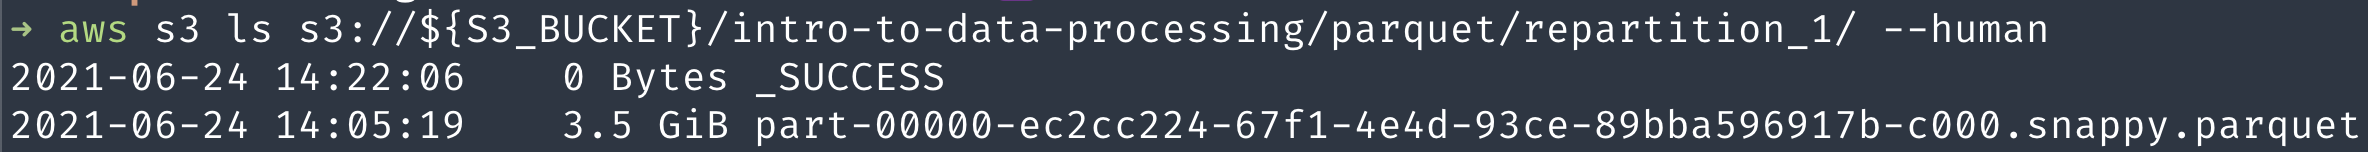

Usually when you're writing output like this, you'll want to determine what the best filesize for your use-case is, do some tests to figure out how to generate that filesize and go from there.

Through a little trial and error, we found out that dividing our data into ~35 partitions gives us the desired file size. Just be careful when repartitioning your data as it can have an impact in performance. Instead of 597 tasks all writing out a tiny bit of data, you're shuffling that data down to however many partitions you select. If that's `1`, then you have a single executor writing that data to the Parquet file.

In [ ]:
df.repartition(35).write.mode('overwrite').parquet("s3://emr-da-demo-us-east-2/intro-to-data-processing/parquet/repartition_35/")

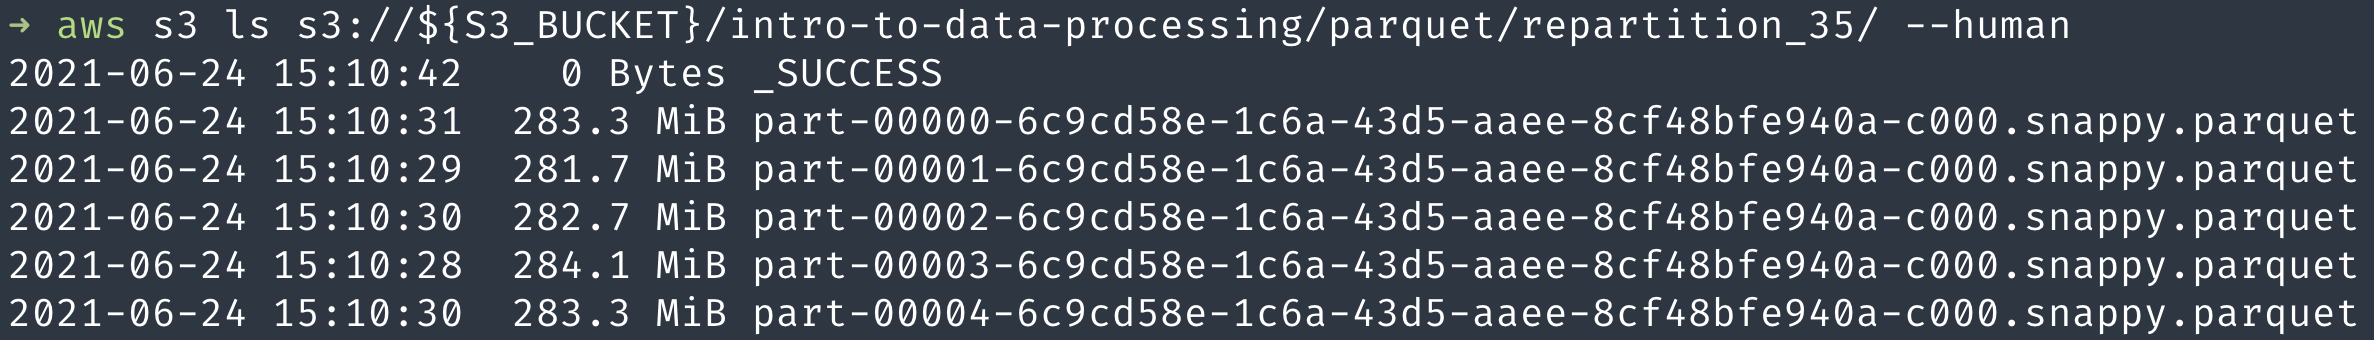